In [1274]:
#pip installs
%pip install plotly
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1409]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#plotting
import plotly.express as px
import plotly.offline as py

#linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import datetime as dt

#prediction
from statsmodels.tsa.arima_model import ARIMA

In [1276]:
#load data from our csv file
#https://github.com/J535D165/CoronaWatchNL/tree/master/data-geo/data-national
cov_data = pd.read_csv('nl_cov_data/dutch_covid_data.csv')

#replace all empty values with 0's
cov_data = cov_data.fillna(0)

#remove row with column names
cov_data = cov_data.iloc[1: , :]

#get contaminations row only
cov_bes = cov_data.iloc[2::3, :]

#get deaths row only
cov_dea = cov_data.iloc[1::3, :]

#get hospital row only
cov_hos = cov_data.iloc[0::3, :]

#duplicates
cov_cum = cov_bes
dea_cum = cov_dea
hos_cum = cov_hos

#get date column
cov_bes_date = cov_bes.loc[:,"Datum"]
cov_dea_date = cov_dea.loc[:,"Datum"]
cov_hos_date = cov_hos.loc[:,"Datum"]

#convert to datetime
cov_bes_date = pd.to_datetime(cov_bes_date)
cov_dea_date = pd.to_datetime(cov_dea_date)
cov_hos_date = pd.to_datetime(cov_hos_date)

#get cumulative contaminations/other stats
cov_cum = cov_cum.loc[:,"AantalCumulatief"]
dea_cum = dea_cum.loc[:,"AantalCumulatief"]
hos_cum = hos_cum.loc[:,"AantalCumulatief"]

#get amount column
cov_bes = cov_bes.loc[:,"Aantal"]
cov_dea = cov_dea.loc[:,"Aantal"]
cov_hos = cov_hos.loc[:,"Aantal"]

#convert to numpy array
num_bes = np.array(cov_bes)
num_cum = np.array(cov_cum)
num_dea = np.array(cov_dea)
num_hos = np.array(cov_hos)
num_dea_cum = np.array(dea_cum)
num_hos_cum = np.array(hos_cum)

In [1277]:
# plot contaminations and cumulative contaminations
contaminations = px.bar(x=cov_bes_date, y=num_bes, height=550, 
               title='Contaminations per day')
contaminations.show()

contaminations_cum = px.bar(x=cov_bes_date, y=num_cum, height=550, 
               title='Cumulative contaminations in the Netherlands')
contaminations_cum.show()

In [1278]:
# plot deaths and cumulative deaths
deaths = px.bar(x=cov_dea_date, y=num_dea, height=550, 
               title='Deaths per day')
deaths.show()

deaths_cum = px.bar(x=cov_dea_date, y=num_dea_cum, height=550, 
               title='Cumulative deaths in the Netherlands')
deaths_cum.show()

In [1279]:
# plot deaths and cumulative deaths
hospital_num = px.bar(x=cov_hos_date, y=num_hos, height=550, 
               title='People entering the hospital per day')
hospital_num.show()

hospital_cum = px.bar(x=cov_hos_date, y=num_hos_cum, height=550, 
               title='Cumulative hospital intakes in the Netherlands')
hospital_cum.show()

When we want to say something about efficiency of measures and lockdowns, we first need to maintain a list of dates in which the covid regulations changed by big amounts.


12-03-2020: thuiswerkadvies, evenementen afgelast

13-03-2020: vliegverbod bepaalde landen

15-03-2020: sluiting horeca en scholen

23-03-2020: begin intelligente lockdown

11-05-2020: versoepelen contactberoepen

27-05-2020: diverse versoepelingen

30-06-2020: diverse versoepelingen

18-08-2020: iets meer maatregelen

27-09-2020: iets meer maatregelen

13-10-2020: lockdown, zware maatregelen

29-04-2020: versoepelingen


In [1280]:
#load data from our csv file
#from https://ourworldindata.org/grapher/covid-stringency-index
stri_data = pd.read_csv('nl_cov_data/covid-stringency-index.csv')

#filter out non dutch values
stri_data = stri_data[stri_data.Entity == "Netherlands"]

#get date data
stri_date = stri_data.loc[:,"Day"]


#convert to datetime
stri_date = pd.to_datetime(stri_date)

#get stringency index data
stri_index = stri_data.loc[:,"stringency_index"]

# plot stringency index
stringency = px.bar(x=stri_date, y=stri_index, height=550, 
               title='Graph of stringency index in the Netherlands')
stringency.show()

In [1281]:
groeifactoren = []

# calculating the growth factor
def groeifactor(delta_cn, delta_cn_old):
    """Returns the number of confirmed cases, Growth Factor=ΔC𝑛/ΔC𝑛−1"""
    return(delta_cn/delta_cn_old)

for i in range(len(cov_bes)):
    #we skip the first element, at is has no predecessor
    if i != 0:
        groeifact = groeifactor(num_bes[i], num_bes[i-1])
        groeifactoren.append(groeifact)

#convert list to numpy array
groeifactoren = np.array(groeifactoren)

#remove first element of dates as this has no r number
cov_bes_date_g = cov_bes_date[1:]

g_grafiek = px.bar(x=cov_bes_date_g, y=groeifactoren, height=550, 
               title='Evolutie groeifactor covid-19')
g_grafiek.show()

In [1282]:
#there is one less data point in our dataset for the first day of contaminations, we adjust this difference for synchronous data
num_bes = num_bes[7:]
num_dea = num_dea[8:]
num_hos = num_hos[8:]
cov_bes_date_g = cov_bes_date_g[6:]

In [1283]:
#remove the 25th of march as this data was not collected properly by the RIVM due to technical problems
outlier = int(cov_bes_date_g.index[cov_bes_date_g == '2021-03-25'].tolist()[0] / 3)
num_bes = np.delete(num_bes, 383)
num_dea = np.delete(num_dea, 383)
num_hos = np.delete(num_hos, 383)
cov_bes_date_g = cov_bes_date_g.loc[cov_bes_date_g != '2021-03-25']

# #DEBUG: check if data is synched
# print(len(num_bes))
# print(len(num_dea))
# print(len(num_hos))
# print(len(cov_bes_date_g))

In [1284]:
#update the stringency index list to fit our time period and remove the 24th and 25th of march
#timeframe = 2020-03-12 until 2020-04-17

#get boundaries and exemptions indexes from dataset
begin = stri_date.index[stri_date == '2020-03-06'].tolist()[0] #81944
end = stri_date.index[stri_date == '2021-04-17'].tolist()[0] #82351
ma24 = stri_date.index[stri_date == '2021-03-24'].tolist()[0] #82327

#adjust timeframe of stringency index dates to contaminations timeframe
stri_date = stri_date.loc[stri_date >= '2020-03-06']
stri_date = stri_date.loc[stri_date <= '2021-04-17']

#adjust timeframe of stringency index dates to remove wrong data points in other dataset
stri_date = stri_date.loc[stri_date != '2021-03-24']
stri_date = stri_date.loc[stri_date != '2021-03-25']

#adjust the stringency index data to above frame
stri_index = stri_index.iloc[45:]
stri_index = stri_index.iloc[:408]

#remove missing elements from dataframe in context
stri_index = stri_index.drop(stri_index.index[384])
stri_index = stri_index.drop(stri_index.index[384])


In [1285]:
#aquire and adjust data about the R number
# The data about the groeifactor was gotten from https://data.rivm.nl/covid-19/COVID-19_reproductiegetal.json
# note that this data is in .json format, we have converted it using http://convertcsv.com/json-to-csv.htm
g_data = pd.read_csv('nl_cov_data/reproductiegetallen.csv')

#get date data
g_date = g_data.loc[:,"Date"]

#convert to datetime
g_date = pd.to_datetime(g_date)

#get average R data
g_data = g_data.loc[:,"Rt_avg"]

#plot data
g_grafiek = px.bar(x=g_date, y=g_data, height=550, 
               title='Evolutie R getal covid-19')
g_grafiek.show()

In [1286]:
#update the reprodutctiegetallen list to fit our time period and remove the 24th and 25th of march
#timeframe = 2020-03-12 until 2020-04-17

#get boundaries and exemptions indexes from dataset
begin = g_date.index[g_date == '2020-03-06'].tolist()[0] #18
end = g_date.index[g_date == '2021-04-17'].tolist()[0] #425
ma24 = g_date.index[g_date == '2021-03-24'].tolist()[0] #401 

#adjust timeframe of reproductiegetallen dates to contaminations timeframe
g_date = g_date.loc[g_date >= '2020-03-06']
g_date = g_date.loc[g_date <= '2021-04-17']

#adjust timeframe of reproductiegetallen dates to remove wrong data points in other dataset
g_date = g_date.loc[g_date != '2021-03-24']
g_date = g_date.loc[g_date != '2021-03-25']

#adjust the reproductiegetallen data to above frame
g_data = g_data.iloc[18:]
g_data = g_data.iloc[:408]

#remove missing elements from dataframe in context
g_data = g_data.drop(g_data.index[401])
g_data = g_data.drop(g_data.index[401])

In [1287]:
#DEBUG
#assure all data is of equal size
print(len(num_bes))
print(len(num_dea))
print(len(num_hos))
print(len(cov_bes_date_g))
print(len(g_data))
print(len(g_date))
print(len(stri_index))
print(len(stri_date))

#DATA explanation
# num_bes = amount of contaminations due to covid-19 in the Netherlands
# num_dea = amount of deaths due to covid-19 in the Netherlands
# num_hos = amount of people taken into the hospital due to covid-19 in the Netherlands
# stri_index = stringency of covid-19 measures in the Netherlands
# g_data = R measure of infectivity covid-19 in the Netherlands
# cov_bes_date_g/g_date/stri_date = timeframe used for our work

406
406
406
406
406
406
406
406


In [1288]:
#Before making a model it is very neccessary to take some weekly averages for our model to use for decision making
#We get average over the last 7 days for all our data points, as it takes approximatly this long for covid-19 measures to take effect
avg_r = g_data.rolling(7).mean()
avg_str = stri_index.rolling(7).mean()

#to get an average of our numpy arrays we need to convert them to pandas dataframes (from np.array)
avg_bes = pd.DataFrame(num_bes).rolling(7).mean()
avg_dea = pd.DataFrame(num_dea).rolling(7).mean()
avg_hos = pd.DataFrame(num_hos).rolling(7).mean()

#to use 7 day means, we need to trim of 6 results, as the first 6 results have no 7 day mean
avg_r = avg_r.iloc[6:]
avg_str = avg_str.iloc[6:]
avg_bes = avg_bes.iloc[6:]
avg_dea = avg_dea.iloc[6:]
avg_hos = avg_hos.iloc[6:]

#because we use 7 day means, we also need to trim the normal data
g_data = g_data.iloc[6:]
stri_index = stri_index.iloc[6:]
num_bes = num_bes[6:]
num_dea = num_dea[6:]
num_hos = num_hos[6:]

#we also have to trim our 3 date objects
cov_bes_date_g = cov_bes_date_g.iloc[6:]
g_date = g_date.iloc[6:]
stri_date = stri_date.iloc[6:]

In [1289]:
#Before making a model, we find it very handy to take delta's from our data, so our model can use delta's as input
#This because in our humble opinion, delta's are a better grade of data adjustment, as they show how rapidly things go wrong (or good)
del_r = g_data.diff().shift(-1)
del_str = stri_index.diff().shift(-1)

#to get an delta of our numpy arrays we need to convert them to pandas dataframes (from np.array)
del_bes = pd.DataFrame(num_bes).diff().shift(-1)
del_dea = pd.DataFrame(num_dea).diff().shift(-1)
del_hos = pd.DataFrame(num_hos).diff().shift(-1)

#because of deltas we need to remove the last element of everything
del_bes = del_bes.iloc[:len(del_bes)-1]
del_dea = del_dea.iloc[:len(del_dea)-1]
del_hos = del_hos.iloc[:len(del_hos)-1]
del_r = del_r.iloc[:len(del_r)-1]
del_str = del_str.iloc[:len(del_str)-1]

#we also compensate all other elements
lengthmin = len(avg_r) - 1
avg_str = avg_str.iloc[:lengthmin]
avg_bes = avg_bes.iloc[:lengthmin]
avg_dea = avg_dea.iloc[:lengthmin]
avg_hos = avg_hos.iloc[:lengthmin]
g_data = g_data.iloc[:lengthmin]
stri_index = stri_index.iloc[:lengthmin]
num_bes = num_bes[:lengthmin]
num_dea = num_dea[:lengthmin]
num_hos = num_hos[:lengthmin]
cov_bes_date_g = cov_bes_date_g.iloc[:lengthmin]
g_date = g_date.iloc[:lengthmin]
stri_date = stri_date.iloc[:lengthmin]
avg_r = avg_r.iloc[:lengthmin]

In [1290]:
# We do all these index resets because we want to be able to freely merge panda's series and dataframes
# This because we want our eventual possible in and outputs in one single dataframe.

# Reset the series indexes of all averages
avg_bes.reset_index(drop=True, inplace=True)
avg_str.reset_index(drop=True, inplace=True)
avg_dea.reset_index(drop=True, inplace=True)
avg_hos.reset_index(drop=True, inplace=True)
avg_r.reset_index(drop=True, inplace=True)

# Reset the series indexes of all data
# Note that the num_ data is not reset, as it is a numpy, not a panda dataframe object
stri_index.reset_index(drop=True, inplace=True)
g_data.reset_index(drop=True, inplace=True)

# Reset the series indexes of all deltas
del_bes.reset_index(drop=True, inplace=True)
del_str.reset_index(drop=True, inplace=True)
del_dea.reset_index(drop=True, inplace=True)
del_hos.reset_index(drop=True, inplace=True)
del_r.reset_index(drop=True, inplace=True)

# Reset the series indexes of all dates
cov_bes_date_g.reset_index(drop=True, inplace=True)
g_date.reset_index(drop=True, inplace=True)
stri_date.reset_index(drop=True, inplace=True)


In [1291]:
np_bes = avg_bes.to_numpy()
np_bes = np.concatenate(np_bes, axis=0)
mean_graph = px.bar(x=cov_bes_date_g, y=np_bes, height=550, 
               title='Evolutie gemiddelde besmettingen in 7 dagen')
mean_graph.show()

np_dbes = del_bes.to_numpy()
np_dbes = np.concatenate(np_dbes, axis=0)
mean_graph = px.bar(x=cov_bes_date_g, y=np_dbes, height=550, 
               title='Evolutie delta besmettingen in 7 dagen')
mean_graph.show()

In [1292]:
#creating one panda dataframe for all covid inputs
cov_data = pd.concat([pd.DataFrame(num_bes), pd.DataFrame(num_dea), pd.DataFrame(num_hos)], axis=1, ignore_index=True)
all_data = pd.concat([cov_data, avg_bes, avg_dea, avg_hos, del_bes, del_dea, del_hos, g_data, avg_r, del_r, stri_index],
                        axis=1, ignore_index=True)

In [1293]:
# We shuffle the dataframe
all_data_shuffled = all_data.sample(frac=1)

# We reset the indexes that were present before shuffle
all_data_shuffled = all_data_shuffled.reset_index(drop=True)

#! DISABLED PART DUE TO OVERWRITING CSV
# Because of the random shuffle, it is impossible to reproduce our results
# Hence we shuffled only once and afterwards saved the shuffled file as csv
# This csv is loaded in when doing our calculations and therefore our results are reproducible

# ! UNCOMMENT THIS TO PRINT CSV DATA
# print(all_data_shuffled.to_csv(index=False))

In [1348]:
#load in dataframe from csv data
ready_data = pd.read_csv('nl_cov_data/cov_data.csv')

# convert data in train and test batch
train, test = train_test_split(ready_data, test_size=0.16)

In [1377]:
#
# ! Note that we printed all data after shuffle to csv files to make our results reproducable
#print(train.to_csv(index=False))
# print("BREAK")
# print(test.to_csv(index=False))

train = pd.read_csv('nl_cov_data/train.csv')
test = pd.read_csv('nl_cov_data/test.csv')

In [ ]:
sns.pairplot(ready_data, x_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], y_vars='Sales', size=7, aspect=0.7)

Measure of dependance: 
 [-2.64786822e-02  3.18258575e-02  1.06458501e-03  1.84965540e-01
 -3.96419679e-02  1.26414599e-03 -8.99959863e+00 -1.97764815e+01
 -2.81961390e+01]
Mean squared error: 54.909
R2 score: 0.721


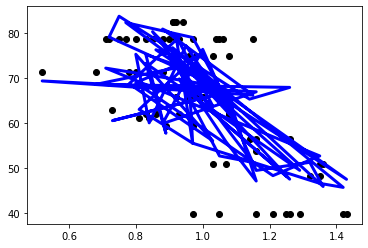

In [1416]:
#linear regression model
# we want to predict the stringency index
# we want to predict this using contaminations, hospital admissions, deaths and the R number
# we have also calculated means and delta's to use as inputs for all of the above inputs

# ? TRAINING
# a pandas dataframe X of the input data and a panda dataframe Y of the output data
X = train[['1', '2', '3', '4', '5', '6', '9', '10', '11']]
y = train['12']

#we use the LinearRegression() method to create a linear regression object
lin_mod = LinearRegression()
lin_mod.fit(X, y)

# * TESTING
# a pandas dataframe X of the input data and a panda dataframe Y of the output data
A = test[['1', '2', '3', '4', '5', '6', '9', '10', '11']]
b = test['12']

# Get predictions based on the training we gave our model
preds = lin_mod.predict(A)

# Save the coefficients of the linear regression    
print("Measure of dependance: \n", lin_mod.coef_)

# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(b, preds))

# The R2 score, ranging from 0 to 1, where 1 is perfect
print("R2 score: %.3f" % r2_score(b, preds))

# ? PLOTTING
plt.scatter(A['9'], b, color='black')
plt.plot(A['9'], preds, color="blue", linewidth=3)
plt.xticks()
plt.yticks()
plt.show()

# ? DEV
#do a dev prediction
# predicted_stri = lin_mod.predict([[5500, 140, 500]])
# print(predicted_stri)

#TODO: #2 algoritme 1: linear regression
#TODO: #3 algoritme 2: C4.5
#TODO: #4 optimaliseer beide algoritmes
#TODO: #5 vergelijk en schrijf paper van 6-8 kantjes

In [1407]:
import itertools 

# Our goal is to iteratively try all combinations to find the perfect score

#save all columns into a list as integers
cols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

#convert list to panda dataframe with only columns
daf = pd.DataFrame(columns=cols)

#get all possible 2pact and 3pact combinations of columns
combs2 = list(itertools.combinations(daf.columns, 2))
combs3 = list(itertools.combinations(daf.columns, 3))
combs4 = list(itertools.combinations(daf.columns, 4))
combs5 = list(itertools.combinations(daf.columns, 5))
combs6 = list(itertools.combinations(daf.columns, 6))
combs7 = list(itertools.combinations(daf.columns, 7))
combs8 = list(itertools.combinations(daf.columns, 8))
combs9 = list(itertools.combinations(daf.columns, 9))
combs10 = list(itertools.combinations(daf.columns, 10))
combs11 = list(itertools.combinations(daf.columns, 11))

lin_mod = LinearRegression()

topinput = []
r2_max = 0
mse_max = 1000

for i in combs9:
    a = str(i[0])
    b = str(i[1])
    c = str(i[2])
    d = str(i[3])
    e = str(i[4])
    f = str(i[5])
    g = str(i[6])
    h = str(i[7])
    ii = str(i[8])
    #j = str(i[9])
    # k = str(i[10])

    #setup training data
    X = train[[a, b, c, d, e, f, g, h, ii]]

    #setup test data
    y = train['12']

    #we use the LinearRegression() method to create a linear regression object
    lin_mod.fit(X, y)

    #setup testing data
    A = test[[a, b, c, d, e, f, g, h, ii]]

    #compare with true data
    z = test['12']

    #predict
    preds = lin_mod.predict(A)

    #diagnostics
    mse = mean_squared_error(z, preds)
    r2 = r2_score(z, preds)

    if r2 > r2_max:
        r2_max = r2
        mse_max = mse
        topinput = [a, b, c, d, e, f, g, h, ii]
    elif r2 == r2_max:
        if mse < mse_max:
            mse_max = mse

print(topinput)
print(r2_max)
print(mse_max)

(0, 1, 2, 3, 4, 5, 6, 7, 8)
(0, 1, 2, 3, 4, 5, 6, 7, 9)
(0, 1, 2, 3, 4, 5, 6, 7, 10)
(0, 1, 2, 3, 4, 5, 6, 7, 11)
(0, 1, 2, 3, 4, 5, 6, 8, 9)
(0, 1, 2, 3, 4, 5, 6, 8, 10)
(0, 1, 2, 3, 4, 5, 6, 8, 11)
(0, 1, 2, 3, 4, 5, 6, 9, 10)
(0, 1, 2, 3, 4, 5, 6, 9, 11)
(0, 1, 2, 3, 4, 5, 6, 10, 11)
(0, 1, 2, 3, 4, 5, 7, 8, 9)
(0, 1, 2, 3, 4, 5, 7, 8, 10)
(0, 1, 2, 3, 4, 5, 7, 8, 11)
(0, 1, 2, 3, 4, 5, 7, 9, 10)
(0, 1, 2, 3, 4, 5, 7, 9, 11)
(0, 1, 2, 3, 4, 5, 7, 10, 11)
(0, 1, 2, 3, 4, 5, 8, 9, 10)
(0, 1, 2, 3, 4, 5, 8, 9, 11)
(0, 1, 2, 3, 4, 5, 8, 10, 11)
(0, 1, 2, 3, 4, 5, 9, 10, 11)
(0, 1, 2, 3, 4, 6, 7, 8, 9)
(0, 1, 2, 3, 4, 6, 7, 8, 10)
(0, 1, 2, 3, 4, 6, 7, 8, 11)
(0, 1, 2, 3, 4, 6, 7, 9, 10)
(0, 1, 2, 3, 4, 6, 7, 9, 11)
(0, 1, 2, 3, 4, 6, 7, 10, 11)
(0, 1, 2, 3, 4, 6, 8, 9, 10)
(0, 1, 2, 3, 4, 6, 8, 9, 11)
(0, 1, 2, 3, 4, 6, 8, 10, 11)
(0, 1, 2, 3, 4, 6, 9, 10, 11)
(0, 1, 2, 3, 4, 7, 8, 9, 10)
(0, 1, 2, 3, 4, 7, 8, 9, 11)
(0, 1, 2, 3, 4, 7, 8, 10, 11)
(0, 1, 2, 3, 4, 7, 9, 10, 11)
(0, 1, 2, 

RESULTATEN

Hoogste resultaat itereren over alle losse mogelijke combinaties:
['4'] 0.5248 93.50

Hoogste resultaat itereren over alle 2 combinaties:
['4', '9'] --> 70.20 MSE, 0.643 R2

Hoogste resultaat itereren over alle 3 combinaties
['3', '4', '9'] --> 61.66 MSE, 0.687 R2

Hoogste resultaat itereren over alle 4 combinaties
['3', '4', '10', '11'] --> 0.700 59.10

Hoogste resultaat itereren over alle 5 combinaties
['3', '4', '9', '10', '11'] --> 0.707, 57.68

Hoogste resultaat itereren over alle 6 combinaties
['3', '4', '5', '9', '10', '11'], 0.708, 57.41

Hoogste resultaat itereren over alle 7 combinaties
['2', '3', '4', '5', '9', '10', '11'], 0.712, 56.65

Hoogste resultaat itereren over alle 8 combinaties
['1', '2', '3', '4', '5', '9', '10', '11'], 0.716, 55.90

Hoogste resultaat itereren over alle 9 combinaties
['1', '2', '3', '4', '5', '6', '9', '10', '11'], 0.721, 54.9

Inputs zorgen voor slechtere score bij meer dan 9 inputs.